# Taxonomic Table and GCN
**(Preprocess raw data and map on common ids)**

In [1]:
import pandas as pd
import numpy as np
import pathlib

### Import and preprocessing functions

In [2]:
# def cleaner funciton for taxonomic table
def import_raw_taxonomic_table(import_file_path):

    # import from file, convert dtypes
    table = pd.read_csv(import_file_path,index_col=0).astype(float)#.convert_dtypes().apply(pd.to_numeric, downcast='unsigned')

    # rename for consistency
    old_cols = table.columns
    new_cols = old_cols.map(lambda x: x.split("_")[0]) 
    table = table.rename(columns={o:n for o,n in zip(old_cols,new_cols)})

    # remove columns with "." in the name
    names_mask = np.vectorize(lambda x: not ("." in x) )
    table=table.loc[:,names_mask(table.columns)]

    # sort indexes
    table.sort_index(axis=0,inplace=True)
    table.sort_index(axis=1,inplace=True)

    return table

# def cleaner funciton for GCN
def import_raw_GCN(import_file_path):

    # import from file, convert dtypes
    proteome = pd.read_csv(import_file_path,sep="\t",index_col=0).astype(float)#convert_dtypes().apply(pd.to_numeric, downcast='unsigned')

    #sort indexes
    proteome = proteome.sort_index(axis=0)
    proteome = proteome.sort_index(axis=1)

    return proteome

### Converison functions for taxnames & MAGids to taxids

#### Translation table

In [3]:
def make_translation_table(translatioin_folder_path):
    import taxopy
    import os
    
    ## make translation_table between taxid and MAGid

    # read UHGGv2.0.1 translation file
    seqid2taxid = pd.read_csv(os.path.join(translatioin_folder_path,"seqid2taxid.map"),sep="\t",header=None)
    
    # extract informations form string
    seqid2taxid = seqid2taxid[0].str.split("|",expand=True)[[2,0]]
    seqid2taxid[[0,1]] = seqid2taxid[0].str.split("_",expand=True)
    seqid2taxid.columns=("taxid", "MAGid", "subseq")
    translation_table = seqid2taxid[["taxid","MAGid"]].drop_duplicates(ignore_index=True).astype({"taxid":int})

    ## add taxname field to translation_table (extraction info from nodes.dmp & names.dmp of UHGGv2.0.1)
    
    # initialize taxopy object form dmp files
    nodes_file = os.path.join(translatioin_folder_path,'nodes.dmp')
    names_file = os.path.join(translatioin_folder_path,'names.dmp')
    taxdb = taxopy.TaxDb(nodes_dmp=nodes_file, names_dmp=names_file)

    # function that converts taxid to taxname
    name_of_id = np.vectorize(lambda x:taxopy.Taxon( x , taxdb=taxdb).rank_name_dictionary["species"].replace("s__",""))

    # add taxname field to translation_table
    translation_table["taxname"] = name_of_id(translation_table["taxid"])   

    # return
    return translation_table

# make translation table
translation_folder_path = "../DATA/metadata/raw/UHGGv2.0.1/translation/"
translation_table = make_translation_table(translation_folder_path)
display(translation_table.head(4))

,taxid,MAGid,taxname
0,3621,MGYG000002602,CAG-274 sp900545305
1,3105,MGYG000002172,UMGS2069 sp900557585
2,4178,MGYG000003132,Dysgonomonas sp900556485
3,5351,MGYG000004167,MGYG000004167


#### Translation functions

In [4]:
# instantiates vectorized translation function from translation table
def make_translator(translation_table,From,To):
    
    # creates a "taxid" series indexed by "taxname", for fast lookup
    ashed_translation_dict = translation_table.drop_duplicates(subset=From).set_index(From,drop=False)[To]

    # create vectorized conversion function
    def get_outname(inname):
        try: return ashed_translation_dict.loc[inname]
        except: return -1 # to be interpreted as non match

    return np.vectorize(get_outname)

# define reindex function for taxonomic_table
def translate_taxonomic_table(taxonomic_table,translation_table):

    # instantiate translator function from taxnames to taxids
    translate = make_translator(translation_table,From="taxname",To="taxid")

    # define new index vector
    new_idx = translate(taxonomic_table.index)

    # mask of the elemets with a good match (will be kept)
    keep_mask = (new_idx!=-1)

    # project and reindex
    trans_txonomic_table = taxonomic_table.loc[keep_mask].set_index(new_idx[keep_mask]).sort_index()

    # set name of new row-index and old col-index vectors
    trans_txonomic_table.index.name="taxid"
    trans_txonomic_table.columns.name="sampleid"

    return trans_txonomic_table.fillna(0).astype(np.float32)


# define reindex function for GCN
def translate_GCN(GCN,translation_table):

    # instantiate translator function from taxnames to taxids
    translate = make_translator(translation_table,From="MAGid",To="taxid")

    # define new index vector
    new_idx = translate(GCN.columns)

    # mask of the elemets with a good match (will be kept)
    keep_mask = (new_idx!=-1)

    # project and reindex
    trans_GCN = GCN.loc[:,keep_mask].T.set_index(new_idx[keep_mask]).T.sort_index(axis=1)

    # set name of new col-index vector
    trans_GCN.columns.name="taxid"

    # aggregate the MAGs that were mapped to the same taxid
    trans_GCN = trans_GCN.T.groupby("taxid").sum().T

    # set name of new col-index vector
    trans_GCN.columns.name="taxid"

    return trans_GCN.fillna(0).astype(np.float32)

### Apply and save to aprquet

In [5]:
# taxonomic table
pathlib.Path("../DATA/datasets/remapped/").mkdir(parents=True, exist_ok=True)
import_file_path = "../DATA/datasets/raw/kaiju_UHGG_table.csv"
export_file_path = "../DATA/datasets/remapped/kaiju_UHGG_table.parq"

taxonomic_table = import_raw_taxonomic_table(import_file_path)
taxonomic_table = translate_taxonomic_table(taxonomic_table,translation_table)
taxonomic_table.to_parquet(export_file_path)

display(pd.read_parquet(export_file_path).head(2))

# GCN
pathlib.Path("../DATA/GCN/remapped/").mkdir(parents=True, exist_ok=True)
import_file_path="../DATA/GCN/raw/proteomes_eggNOG_OGs_matrix.tsv.gz"
export_file_path="../DATA/GCN/remapped/GCN_eggNOG_OGs.parq"

GCN = import_raw_GCN(import_file_path)
GCN = translate_GCN(GCN,translation_table)
GCN.to_parquet(export_file_path)

display(pd.read_parquet(export_file_path).head(2))

sampleid,SRR5935740,SRR5935741,SRR5935761,SRR5935762,SRR5935767,SRR5935773,SRR5935807,SRR5935827,SRR5935833,SRR5935843,...,SRR6468705,SRR6468706,SRR6468707,SRR6468710,SRR6468711,SRR6468712,SRR6468713,SRR6468714,SRR6468715,SRR6468716
taxid,,,,,,,,,,,,,,,,,,,,,
8,128.0,2218.0,89.0,723.0,29.0,2478.0,248.0,1338.0,86.0,275.0,...,55.0,63.0,218.0,6.0,70.0,388.0,30.0,58.0,42.0,48.0
14,1.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,...,5.0,4.0,0.0,2.0,3.0,2.0,2.0,0.0,7.0,0.0


taxid,8,14,17,23,25,26,27,29,30,31,...,6117,6118,6119,6120,6121,6122,6123,6124,6125,6127
eggNOG_OGs,,,,,,,,,,,,,,,,,,,,,
2DPRW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COG0001,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


# UHGG metadata (genome lengths)
**(import, remap on taxid, extract genome length, save as parquet)**

In [7]:
# extracts metadata and indexes them according to taxid, average when multiple MAGids are mapped on the same taxid
def extract_genome_length_of_taxa(metadata):

    # instantiate translator function from MAGids to taxids
    translate = make_translator(translation_table,From="MAGid",To="taxid")

    # define taxid vector
    metadata["taxid"] = translate(metadata["Genome"])

    # select rows with good taxid match, groupby taxid and extract average length over the group of genomes associated to the taxid
    metadata = metadata.query("taxid!=-1").groupby("taxid").agg({"Length":np.mean}).sort_index()

    return metadata


# process
pathlib.Path("../DATA/metadata/remapped/").mkdir(parents=True, exist_ok=True)
import_file_path = "../DATA/metadata/raw/UHGGv2.0.1/genomes-all_metadata.tsv.gz"
export_file_path = "../DATA/metadata/remapped/genome_length.parq"
metadata = pd.read_csv(import_file_path, sep="\t")[["Genome","Length","Lineage"]]
genome_length = extract_genome_length_of_taxa(metadata)
genome_length.to_parquet(export_file_path)

# reimport check
pd.read_parquet(export_file_path).head(4)

,Length
taxid,
8,1691878.0
14,1448574.0
17,1739504.0
23,3991467.0


# Thresholding and renormalizaiton of Taxonomic Table
**(apply threshold according to logderivative rule, normalize reads count for genome length, make data compositional by normalizing columns to one)**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# notmalize columns to one in order to obtain compositional data
def normalize_cols(table):
    return table/table.sum(axis=0)

# normalize rows according to genome length in order to obtain values proportional to cell counts
length_metadata = pd.read_parquet("../DATA/metadata/remapped/genome_length.parq")["Length"]
def normalize_rows(table,length_metadata=length_metadata):
    return table.divide(length_metadata.loc[table.index],axis=0)

# apply a definite cutoff value to the talbe
def apply_cutoff(table,threshold,renorm_cols=False):
    table = table.copy()
    table[table<threshold] = 0
    if renorm_cols:
        table = normalize_cols(table)
    return table

#### Functions threshold computation/visualization

In [10]:
# compute threshold according to rule (minima of log deivative)
def compute_threshold(table, Nmesh=150, return_functions=False,logder=True):

    # instantiate vectorized "average alpha div" function
    average_alpha_div = np.vectorize(lambda tr:(table > tr).sum(axis=0).mean() )

    # define domain extrema
    vmin = table.min().min()+1e-9
    vmax = table.max().max()

    # compute function values
    threshold = np.logspace(np.log10(vmin),np.log10(vmax),Nmesh)
    alpha = average_alpha_div(threshold)

    # compute derivative values
    if logder:
        threshold2    = 10**((np.log10(threshold[1:])+np.log10(threshold[:-1]))/2)
        dlogthreshold =      (np.log10(threshold[1:])-np.log10(threshold[:-1]))
        dalpha        =      (             alpha[1:] -             alpha[:-1] )
        diff          = dalpha/dlogthreshold
    else:
        threshold2 = (threshold[1:]+threshold[:-1])/2
        dthreshold = (threshold[1:]-threshold[:-1])
        dalpha     = (    alpha[1:]-    alpha[:-1])
        diff = dalpha/dthreshold

    # smooth out diff
    diff = pd.Series(diff).rolling(int(np.ceil(0.05*Nmesh)),center=True).mean().fillna(pd.Series(diff)).values

    # compute threshold value
    thr = threshold2[np.argmin(diff)]

    # returns
    if return_functions:
        return thr, (threshold,alpha), (threshold2,diff)
    else:
        return thr

In [11]:
# computes threshold and shows pictures illustrating the logic of the choice of the threshold
def compute_visualize_threshold(taxonomic_table, Nmesh=150,logder=True):

    fig, axs = plt.subplots(1,3,figsize=[15,5])

    ## compute threshold, alpha div function, and derivative
    thr, (threshold, alpha), (threshold2,diff) = compute_threshold(taxonomic_table,Nmesh=Nmesh, return_functions=True,logder=logder)

    ## histogram of values in taxonomic_table

    # define log bins
    minv  = taxonomic_table.values.ravel().min() + 1e-9
    maxv  = taxonomic_table.values.ravel().max()
    Nbins = 20
    bins  = np.logspace(np.log10(minv),np.log10(maxv+1),Nbins)

    # histogram
    plt.sca(axs[0])
    plt.hist(taxonomic_table.values.ravel(),bins=bins)
    plt.axvline(thr,color="red")
    plt.xscale("log")
    plt.title("Histogram of the values in table")
    plt.xlabel("values of table")
    plt.ylabel("counts")


    ## plot of alpha diversity and derivative
    
    # plt function
    plt.sca(axs[1])
    plt.plot(threshold,alpha,marker=".")
    plt.axvline(thr,color="red")
    plt.title("Average alpha-div as function of threshold-value")
    plt.xscale("log")
    plt.xlabel("threshold value $\eta$")
    plt.ylabel("average alpha div <a>")

    # plt derivative
    plt.sca(axs[2])
    plt.plot(threshold2,diff,marker=".")
    plt.axvline(thr,color="red")
    plt.title("derivative of average alpha-div as function of threshold-value")
    plt.xscale("log")
    plt.xlabel("threshold value $\eta$")
    if logder:
        plt.ylabel(r"$\frac{d<a>}{d\; \log_{10}(\eta)}$")
    else:
        plt.ylabel(r"$\frac{d<a>}{d\; \eta}$")
    plt.xscale("log")

    # adjust to accomodate suptitle
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    fig.suptitle(f"(in red) threshold={thr}")

    # return threshold value
    return thr

#### Apply

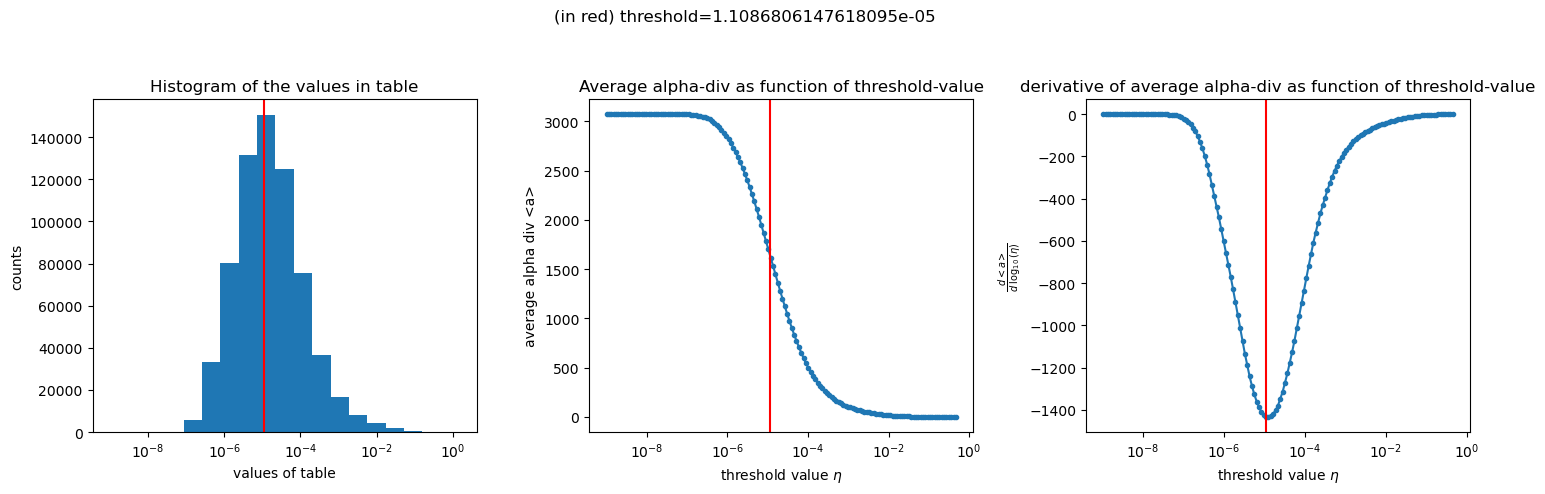

In [12]:
# define paths
inport_file_path = "../DATA/datasets/remapped/kaiju_UHGG_table.parq"
export_file_path = "../DATA/datasets/remapped/taxonomic_table.parq"

# import taxonomic table
taxonomic_table = pd.read_parquet(inport_file_path)

# normalize taxonomic table
taxonomic_table = normalize_cols(normalize_rows(taxonomic_table))

# compute and apply threshold
thr = compute_visualize_threshold(taxonomic_table=taxonomic_table,Nmesh=150,logder=True)
taxonomic_table = apply_cutoff(taxonomic_table,threshold=thr,renorm_cols=True)

# drop "empty" taxids
taxonomic_table = taxonomic_table.loc[taxonomic_table.sum(axis=1)!=0]

# export to parquet
taxonomic_table.to_parquet(export_file_path)

# Metadata of samples (Helthy/Unhealthy)
**(import, preprocess, extract health informations, save as parquet)**

In [13]:
def clean_metadata(import_file_path, export_file_path):

    # import all metadata
    metadata = pd.read_csv(import_file_path,index_col=0).sort_index()

    # set name of index
    metadata.index.name = "sampleid"

    # select only the samples for which we have the data
    SRR_mask = metadata.index.str.startswith("SRR")   # select only the SRR series which is the one for which we have the data
    metadata = metadata.loc[SRR_mask]

    # export diagnosis informations
    metadata["ishealthy"] = (metadata["diagnosis"]=="H")  # "ishealty" filter
    metadata[["ishealthy","diagnosis"]].to_parquet(export_file_path)

# process
pathlib.Path("../DATA/metadata/remapped/").mkdir(parents=True, exist_ok=True)
import_file_path = "../DATA/metadata/raw/samples/metadata_db_run2.csv"
export_file_path = "../DATA/metadata/remapped/sample_health.parq"
clean_metadata(import_file_path, export_file_path)

# reimport check
pd.read_parquet(export_file_path).head(4)

,ishealthy,diagnosis
sampleid,,
SRR5935740,True,H
SRR5935741,False,UC
SRR5935761,False,UC
SRR5935762,False,CD


# Functional Groups Annotations

#### Annotations with file provided by UHGGv2.0.1

In [14]:
# file paths
import_file_path = "../DATA/metadata/raw/UHGGv2.0.1/annotations.tsv.gz"
export_file_path = "../DATA/metadata/remapped/functional_groups_mapping.parq"

# import annotations_table file and drops the lines with no categorical informations
annotations_table = pd.read_csv(import_file_path,sep="\t",index_col=1).drop("-")

# selact main group when many are assigned (add as a column)
annotations_table["COG_category"] = np.where(annotations_table.index.str.len()==1,annotations_table.index,annotations_table.index.str[0]) 

# transform functional_group annotation to presence absence matrix for all the couples (OGs,cathegory)
functional_groups_mapping = pd.get_dummies(annotations_table["COG_category"]).set_index(annotations_table["eggNOG_OGs"]).groupby("eggNOG_OGs").agg(np.any)

# import full OGs set
full_OGs_set = pd.read_parquet(f"../DATA/GCN/remapped/GCN_eggNOG_OGs.parq",columns=["eggNOG_OGs"])

# create complete annotations_table padding with "False"
functional_groups_mapping = functional_groups_mapping.join(full_OGs_set,how="outer").fillna(False) 

# print coverage number and coverage fraction (of ortologs matched with groups)
print("coverage:")
print(f"{np.sum(functional_groups_mapping.sum(axis=1)!=0)}/{len(functional_groups_mapping)} ortologs, {np.sum(functional_groups_mapping.sum(axis=1)!=0)/len(functional_groups_mapping)*100}%")

# assign nonassigned ortologs to cathegory "S" ("unknown function")
functional_groups_mapping["S"] = np.where(functional_groups_mapping.sum(axis=1)==0, True, functional_groups_mapping["S"] )

# normalize to obtain "belonging degree" of ortologs fo groups (whene more than one is assigend)
functional_groups_mapping = functional_groups_mapping/functional_groups_mapping.sum(axis=1).values[:,None]

# export to parquet
functional_groups_mapping.to_parquet(export_file_path)

# diplay
display(functional_groups_mapping)  # missing R and Y representatives

coverage:
5221/6407 ortologs, 81.48899641017637%


,A,B,C,D,E,F,G,H,I,J,...,M,N,O,P,Q,S,T,U,V,Z
eggNOG_OGs,,,,,,,,,,,,,,,,,,,,,
2DPRW,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
COG0001,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,0.0,0.0
COG0002,0.0,0.0,0.5,0.000000,0.500000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
COG0003,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.333333,0.333333,0.000000,0.0,0.000000,0.000000,0.0,0.0
COG0004,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.166667,0.000000,0.166667,0.166667,0.0,0.166667,0.166667,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
arCOG15224,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0
arCOG15249,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0
arCOG15258,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0


#### Annotation with file taken from COG:

(reference source) https://www.ncbi.nlm.nih.gov/research/cog-project/

(COGs) https://ftp.ncbi.nih.gov/pub/COG/COG2020/data/

(arCOGs) https://ftp.ncbi.nih.gov/pub/wolf/COGs/arCOG/ 

In [16]:
# file paths
import_file_path    = "../DATA/metadata/raw/COG/COG/cog-20.def.tab"
import_file_path_ar = "../DATA/metadata/raw/COG/arCOG/ar14.arCOGdef.tab"
export_file_path    = "../DATA/metadata/remapped/functional_groups_mapping_v2.parq"

# import annotations_table file and drops the lines with no categorical informations
annotations_table = pd.read_csv(import_file_path,sep="\t",encoding="cp1252",header=None)
annotations_table.columns=["eggNOG_OGs","COG_category","description","associated_gene","associated_pathway","PubMed_ID","PDB_id"]
annotations_table = annotations_table.set_index("COG_category",drop=True)
annotations_table_ar = pd.read_csv(import_file_path_ar,sep="\t",encoding="cp1252")
annotations_table_ar.columns=["eggNOG_OGs","COG_category","associated_gene","description","COG/Supercluster","Pfam","CDD","TIGR"]
annotations_table_ar = annotations_table_ar.set_index("COG_category",drop=True)

# selact main group when many are assigned (add as a column)
annotations_table   ["COG_category"] = np.where(annotations_table   .index.str.len()==1,annotations_table   .index,annotations_table   .index.str[0]) 
annotations_table_ar["COG_category"] = np.where(annotations_table_ar.index.str.len()==1,annotations_table_ar.index,annotations_table_ar.index.str[0]) 

# transform functional_group annotation to presence absence matrix for all the couples (OGs,cathegory)
functional_groups_mapping    = pd.get_dummies(annotations_table   ["COG_category"]).set_index(annotations_table   ["eggNOG_OGs"]).groupby("eggNOG_OGs").agg(np.any)
annotations_presence_absence_ar = pd.get_dummies(annotations_table_ar["COG_category"]).set_index(annotations_table_ar["eggNOG_OGs"]).groupby("eggNOG_OGs").agg(np.any)
functional_groups_mapping = pd.concat([functional_groups_mapping,annotations_presence_absence_ar],axis=0)

# import full OGs set
full_OGs_set = pd.read_parquet(f"../DATA/GCN/remapped/GCN_eggNOG_OGs.parq",columns=["eggNOG_OGs"])

# create complete annotations_table padding with "False"
functional_groups_mapping = functional_groups_mapping.join(full_OGs_set,how="outer").fillna(False).loc[full_OGs_set.index] 

# print coverage number and coverage fraction (of ortologs matched with groups)
print("coverage:")
print(f"{np.sum(functional_groups_mapping.sum(axis=1)!=0)}/{len(functional_groups_mapping)} ortologs, {np.sum(functional_groups_mapping.sum(axis=1)!=0)/len(functional_groups_mapping)*100}%")

# assign nonassigned ortologs to cathegory "S" ("unknown function")
functional_groups_mapping["S"] = np.where(functional_groups_mapping.sum(axis=1)==0, True, functional_groups_mapping["S"] )

# normalize to obtain "belonging degree" of ortologs fo groups (whene more than one is assigend)
functional_groups_mapping = functional_groups_mapping/functional_groups_mapping.sum(axis=1).values[:,None]

# export to parquet
functional_groups_mapping.to_parquet("../DATA/metadata/remapped/functional_groups_mapping_v2.parq")

# diplay
display(functional_groups_mapping)  # missing R and Y representatives


coverage:
6354/6407 ortologs, 99.17277977212424%


,A,B,C,D,E,F,G,H,I,J,...,P,Q,R,S,T,U,V,W,X,Z
eggNOG_OGs,,,,,,,,,,,,,,,,,,,,,
2DPRW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
COG0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COG0002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COG0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COG0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
arCOG15224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
arCOG15249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
arCOG15258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
